## Importing Libraries

In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import os
import kagglehub
import struct

## Set Random Seeds

In [82]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Define CNN-Softmax Model
This class defines a Convolutional Neural Network (CNN) with a Softmax classifier for multi-class classification.

In [83]:
class CNNSoftmax(tf.keras.Model):
    """CNN model with Softmax classifier"""

    def __init__(self, num_classes=10, input_shape=(28, 28, 1)):
        super(CNNSoftmax, self).__init__()
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu',
                                           input_shape=input_shape,
                                           kernel_initializer='he_normal')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))

        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu',
                                           kernel_initializer='he_normal')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))

        # Dense layers
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1024, activation='relu',
                                        kernel_initializer='he_normal')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        return self.fc2(x)

    def get_features(self, x, training=None):
        """Extract features before final classification layer"""
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        return x

## Define CNN-SVM Model
This class defines a CNN with an SVM classifier implemented using hinge loss for multi-class classification.

In [84]:
class CNNSVM(tf.keras.Model):
    """CNN model with SVM classifier (using hinge loss)"""

    def __init__(self, num_classes=10, input_shape=(28, 28, 1), C=1.0):
        super(CNNSVM, self).__init__()
        self.num_classes = num_classes
        self.C = C  # SVM penalty parameter

        # Convolutional layers (same as CNN-Softmax)
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu',
                                           input_shape=input_shape,
                                           kernel_initializer='he_normal')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))

        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu',
                                           kernel_initializer='he_normal')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))

        # Dense layers
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1024, activation='relu',
                                        kernel_initializer='he_normal')
        self.dropout = tf.keras.layers.Dropout(0.5)
        # No activation for SVM output layer
        self.fc2 = tf.keras.layers.Dense(num_classes, kernel_initializer='he_normal')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        return self.fc2(x)

    def svm_loss(self, y_true, y_pred):
        """Custom SVM hinge loss with L2 regularization"""
        # Convert one-hot to class indices
        y_true_idx = tf.argmax(y_true, axis=1)

        # Get correct class scores
        batch_size = tf.shape(y_pred)[0]
        indices = tf.stack([tf.range(batch_size), tf.cast(y_true_idx, tf.int32)], axis=1)
        correct_scores = tf.gather_nd(y_pred, indices)

        # Calculate margins
        margins = tf.maximum(0.0, y_pred - tf.expand_dims(correct_scores, 1) + 1.0)

        # Set margin for correct class to 0
        mask = tf.one_hot(y_true_idx, self.num_classes)
        margins = margins * (1.0 - mask)

        # Hinge loss
        # hinge_loss = tf.reduce_mean(tf.reduce_sum(margins, axis=1))

        # # L2 regularization on weights
        # l2_loss = tf.reduce_sum([tf.nn.l2_loss(var) for var in self.trainable_variables
        #                         if 'kernel' in var.name])

        # return hinge_loss + self.C * l2_loss
        hinge_loss = tf.reduce_mean(tf.reduce_sum(margins, axis=1))
        l2_loss = tf.reduce_sum([tf.nn.l2_loss(var) for var in self.trainable_variables if 'kernel' in var.name])
        num_samples = 60000.0  # MNIST train size
        return hinge_loss + (self.C / num_samples) * l2_loss

## Define ModelEvaluator Class
the ModelEvaluator class have helper methods like data loading and noise addition.

In [85]:
class ModelEvaluator:
    """Class to handle model training, evaluation, and comparison"""

    def __init__(self):
        self.history = {}
        self.results = {}

    @staticmethod
    def load_mnist_data():
        """Load and preprocess MNIST data from ubyte files"""
        try:
            # Download MNIST using kagglehub
            path = kagglehub.dataset_download("hojjatk/mnist-dataset")
            print(f"Dataset downloaded to: {path}")
            print("Files in downloaded directory:", os.listdir(path))  # Inspect directory contents

            # Define paths to the ubyte files (corrected paths)
            train_images_path = os.path.join(path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
            train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
            test_images_path = os.path.join(path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
            test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

            def read_ubyte_images(filename):
                if not os.path.isfile(filename):
                    raise FileNotFoundError(f"{filename} is not a file.")
                with open(filename, 'rb') as f:
                    magic, num_images, num_rows, num_cols = struct.unpack(">IIII", f.read(16))
                    images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
                return images

            def read_ubyte_labels(filename):
                if not os.path.isfile(filename):
                    raise FileNotFoundError(f"{filename} is not a file.")
                with open(filename, 'rb') as f:
                    magic, num_items = struct.unpack(">II", f.read(8))
                    labels = np.frombuffer(f.read(), dtype=np.uint8)
                return labels

            # Load data from ubyte files
            X_train = read_ubyte_images(train_images_path)
            y_train = read_ubyte_labels(train_labels_path)
            X_test = read_ubyte_images(test_images_path)
            y_test = read_ubyte_labels(test_labels_path)

        except Exception as e:
            print(f"Error loading from kagglehub files: {e}")
            print("Falling back to tf.keras.datasets...")
            # Fallback to keras datasets
            (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

        # Normalize pixel values to [0, 1]
        X_train = X_train.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        # Reshape for CNN input
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)

        # Convert labels to one-hot encoding
        y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
        y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

        print(f"Training data shape: {X_train.shape}")
        print(f"Test data shape: {X_test.shape}")

        return (X_train, y_train, y_train_onehot), (X_test, y_test, y_test_onehot)

    def add_noise(self, X, noise_level=0.1):
        """Add Gaussian noise to test robustness"""
        noise = np.random.normal(0, noise_level, X.shape)
        return np.clip(X + noise, 0, 1)

## Training CNN-Softmax

In [86]:
def train_cnn_softmax(self, X_train, y_train, X_test, y_test, epochs=10):
    """Train CNN with Softmax classifier"""
    print("\n" + "="*50)
    print("Training CNN-Softmax Model")
    print("="*50)

    model = CNNSoftmax()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, verbose=1
    )

    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr],
        verbose=1
    )

    training_time = time.time() - start_time

    self.history['cnn_softmax'] = history.history
    self.results['cnn_softmax'] = {
        'model': model,
        'training_time': training_time
    }

    print(f"CNN-Softmax training completed in {training_time:.2f} seconds")
    return model

setattr(ModelEvaluator, 'train_cnn_softmax', train_cnn_softmax)

## Training CNN-SVM

In [87]:
def train_cnn_svm(self, X_train, y_train, X_test, y_test, epochs=10):
    """Train CNN with SVM classifier"""
    print("\n" + "="*50)
    print("Training CNN-SVM Model")
    print("="*50)

    model = CNNSVM(C=1.0)

    # Custom training loop for SVM
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Metrics for the current epoch
        train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
        train_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
        val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
        val_acc_metric = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

        # Training
        for i in range(0, len(X_train), 128):
            batch_x = X_train[i:i+128]
            batch_y = y_train[i:i+128]

            with tf.GradientTape() as tape:
                predictions = model(batch_x, training=True)
                loss = model.svm_loss(batch_y, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update metrics after each batch
            train_loss_metric.update_state(loss)
            train_acc_metric.update_state(batch_y, tf.nn.softmax(predictions))

        # Validation
        val_predictions = model(X_test, training=False)
        val_loss = model.svm_loss(y_test, val_predictions)
        val_loss_metric.update_state(val_loss)
        val_acc_metric.update_state(y_test, tf.nn.softmax(val_predictions))

        # Record history
        history['loss'].append(float(train_loss_metric.result()))
        history['accuracy'].append(float(train_acc_metric.result()))
        history['val_loss'].append(float(val_loss_metric.result()))
        history['val_accuracy'].append(float(val_acc_metric.result()))

        print(f"Loss: {train_loss_metric.result():.4f} - "
              f"Accuracy: {train_acc_metric.result():.4f} - "
              f"Val Loss: {val_loss_metric.result():.4f} - "
              f"Val Accuracy: {val_acc_metric.result():.4f}")

    training_time = time.time() - start_time

    self.history['cnn_svm'] = history
    self.results['cnn_svm'] = {
        'model': model,
        'training_time': training_time
    }

    print(f"CNN-SVM training completed in {training_time:.2f} seconds")
    return model

setattr(ModelEvaluator, 'train_cnn_svm', train_cnn_svm)

## Model Evaluation

In [88]:
# Continuing the ModelEvaluator class definition
def evaluate_models(self, X_test, y_test, y_test_onehot):
    """Comprehensive evaluation of both models"""
    print("\n" + "="*50)
    print("Evaluating Models")
    print("="*50)

    results = {}

    for model_name in ['cnn_softmax', 'cnn_svm']:
        model = self.results[model_name]['model']
        print(f"\nEvaluating {model_name.upper()}...")

        # Clean test accuracy
        if model_name == 'cnn_softmax':
            test_pred = model.predict(X_test)
            test_pred_classes = np.argmax(test_pred, axis=1)
        else:
            test_pred_logits = model(X_test, training=False)
            test_pred = tf.nn.softmax(test_pred_logits)
            test_pred_classes = np.argmax(test_pred, axis=1)

        clean_accuracy = np.mean(test_pred_classes == y_test)

        # Noisy test accuracy (robustness)
        X_test_noisy = self.add_noise(X_test, noise_level=0.1)
        if model_name == 'cnn_softmax':
            noisy_pred = model.predict(X_test_noisy)
            noisy_pred_classes = np.argmax(noisy_pred, axis=1)
        else:
            noisy_pred_logits = model(X_test_noisy, training=False)
            noisy_pred = tf.nn.softmax(noisy_pred_logits)
            noisy_pred_classes = np.argmax(noisy_pred, axis=1)

        noisy_accuracy = np.mean(noisy_pred_classes == y_test)

        # Classification report
        report = classification_report(y_test, test_pred_classes,
                                     target_names=[str(i) for i in range(10)],
                                     output_dict=True)

        # ROC-AUC (multiclass)
        y_test_bin = label_binarize(y_test, classes=list(range(10)))
        test_pred_proba = test_pred.numpy() if hasattr(test_pred, 'numpy') else test_pred

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(10):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        macro_auc = np.mean(list(roc_auc.values()))

        results[model_name] = {
            'clean_accuracy': clean_accuracy,
            'noisy_accuracy': noisy_accuracy,
            'robustness_drop': clean_accuracy - noisy_accuracy,
            'precision': report['macro avg']['precision'],
            'recall': report['macro avg']['recall'],
            'f1_score': report['macro avg']['f1-score'],
            'macro_auc': macro_auc,
            'training_time': self.results[model_name]['training_time'],
            'confusion_matrix': confusion_matrix(y_test, test_pred_classes),
            'classification_report': report,
            'roc_data': {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
        }

        print(f"Clean Accuracy: {clean_accuracy:.4f}")
        print(f"Noisy Accuracy: {noisy_accuracy:.4f}")
        print(f"Robustness Drop: {clean_accuracy - noisy_accuracy:.4f}")
        print(f"F1-Score: {report['macro avg']['f1-score']:.4f}")
        print(f"Macro AUC: {macro_auc:.4f}")

    return results

setattr(ModelEvaluator, 'evaluate_models', evaluate_models)

## Create Visualizations

In [90]:
def create_visualizations(self, results):
    """Create separate visualizations, each saved as individual PNG files"""
    print("\n" + "="*50)
    print("Creating Visualizations")
    print("="*50)

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')

    # 1. Model Accuracy Comparison
    plt.figure(figsize=(8, 6))
    for model_name in ['cnn_softmax', 'cnn_svm']:
        epochs = range(1, len(self.history[model_name]['accuracy']) + 1)
        plt.plot(epochs, self.history[model_name]['accuracy'],
                 label=f'{model_name.upper()} Train', linewidth=2)
        plt.plot(epochs, self.history[model_name]['val_accuracy'],
                 label=f'{model_name.upper()} Val', linestyle='--', linewidth=2)
    plt.title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('accuracy_comparison.png', dpi=300)
    plt.show()
    plt.close()

    # 2. Model Loss Comparison
    plt.figure(figsize=(8, 6))
    for model_name in ['cnn_softmax', 'cnn_svm']:
        epochs = range(1, len(self.history[model_name]['loss']) + 1)
        plt.plot(epochs, self.history[model_name]['loss'],
                 label=f'{model_name.upper()} Train', linewidth=2)
        plt.plot(epochs, self.history[model_name]['val_loss'],
                 label=f'{model_name.upper()} Val', linestyle='--', linewidth=2)
    plt.title('Model Loss Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_comparison.png', dpi=300)
    plt.show()
    plt.close()

    # 3. Performance Metrics Comparison
    plt.figure(figsize=(10, 6))
    metrics = ['clean_accuracy', 'noisy_accuracy', 'f1_score', 'macro_auc']
    x_pos = np.arange(len(metrics))
    width = 0.35

    softmax_scores = [results['cnn_softmax'][m] for m in metrics]
    svm_scores = [results['cnn_svm'][m] for m in metrics]

    plt.bar(x_pos - width/2, softmax_scores, width, label='CNN-Softmax', alpha=0.8)
    plt.bar(x_pos + width/2, svm_scores, width, label='CNN-SVM', alpha=0.8)

    plt.title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.xticks(x_pos, [m.replace('_', ' ').title() for m in metrics], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('performance_metrics.png', dpi=300)
    plt.show()
    plt.close()

    # 4. Robustness Analysis
    plt.figure(figsize=(8, 6))
    robustness_data = {
        'CNN-Softmax': [results['cnn_softmax']['clean_accuracy'],
                        results['cnn_softmax']['noisy_accuracy']],
        'CNN-SVM': [results['cnn_svm']['clean_accuracy'],
                    results['cnn_svm']['noisy_accuracy']]
    }

    x = ['Clean Data', 'Noisy Data']
    for model, scores in robustness_data.items():
        plt.plot(x, scores, 'o-', linewidth=2, markersize=8, label=model)

    plt.title('Robustness Analysis', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('robustness_analysis.png', dpi=300)
    plt.show()
    plt.close()

    # 5. CNN-Softmax Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['cnn_softmax']['confusion_matrix'], annot=True, fmt='d',
                cmap='Blues')
    plt.title('CNN-Softmax Confusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('softmax_confusion_matrix.png', dpi=300)
    plt.show()
    plt.close()

    # 6. CNN-SVM Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['cnn_svm']['confusion_matrix'], annot=True, fmt='d',
                cmap='Oranges')
    plt.title('CNN-SVM Confusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('svm_confusion_matrix.png', dpi=300)
    plt.show()
    plt.close()

    # 7. ROC Curves (Macro Average)
    plt.figure(figsize=(8, 6))
    base_fpr = np.linspace(0, 1, 101)
    for model_name in ['cnn_softmax', 'cnn_svm']:
        tprs = []
        for i in range(10):
            fpr = results[model_name]['roc_data']['fpr'][i]
            tpr = results[model_name]['roc_data']['tpr'][i]
            tprs.append(np.interp(base_fpr, fpr, tpr))
        tpr_mean = np.mean(tprs, axis=0)
        auc_mean = results[model_name]['macro_auc']

        plt.plot(base_fpr, tpr_mean, linewidth=2,
                 label=f'{model_name.upper()} (AUC = {auc_mean:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('ROC Curves (Macro Average)', fontsize=12, fontweight='bold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()
    plt.close()

    # 8. Training Time Comparison
    plt.figure(figsize=(6, 6))
    models = ['CNN-Softmax', 'CNN-SVM']
    times = [results['cnn_softmax']['training_time'],
             results['cnn_svm']['training_time']]
    colors = ['skyblue', 'lightcoral']

    bars = plt.bar(models, times, color=colors, alpha=0.8)
    plt.title('Training Time Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Time (seconds)')

    # Add value labels on bars
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('training_time.png', dpi=300)
    plt.show()
    plt.close()

    # 9. Per-Class F1-Score
    plt.figure(figsize=(10, 6))
    classes = list(range(10))
    softmax_f1 = [results['cnn_softmax']['classification_report'][str(i)]['f1-score']
                  for i in classes]
    svm_f1 = [results['cnn_svm']['classification_report'][str(i)]['f1-score']
              for i in classes]

    x_pos = np.arange(len(classes))
    width = 0.35

    plt.bar(x_pos - width/2, softmax_f1, width, label='CNN-Softmax', alpha=0.8)
    plt.bar(x_pos + width/2, svm_f1, width, label='CNN-SVM', alpha=0.8)

    plt.title('Per-Class F1-Score', fontsize=12, fontweight='bold')
    plt.xlabel('Digit Class')
    plt.ylabel('F1-Score')
    plt.xticks(x_pos, classes)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('per_class_f1.png', dpi=300)
    plt.show()
    plt.close()

    # 10. Performance Summary Table (as a plot)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')

    summary_data = []
    for model in ['cnn_softmax', 'cnn_svm']:
        summary_data.append([
            model.replace('_', '-').upper(),
            f"{results[model]['clean_accuracy']*100:.2f}",
            f"{results[model]['f1_score']*100:.2f}",
            f"{results[model]['macro_auc']*100:.2f}",
            f"{results[model]['robustness_drop']*100:.2f}",
            f"{results[model]['training_time']:.1f}s"
        ])

    table = ax.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy (%)', 'F1-Score (%)', 'AUC (%)',
                                'Robustness Drop (%)', 'Training Time (s)'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax.set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)
    plt.savefig('performance_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

setattr(ModelEvaluator, 'create_visualizations', create_visualizations)

## Result Summary

In [91]:
def generate_results_table(self, results):
    """Generate detailed results table for paper"""
    table_data = {
        'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (%)',
                  'F1-Score (%)', 'AUC (%)', 'Robustness Drop (%)',
                  'Training Time (s)'],
        'CNN-Softmax': [
            f"{results['cnn_softmax']['clean_accuracy']*100:.2f}",
            f"{results['cnn_softmax']['precision']*100:.2f}",
            f"{results['cnn_softmax']['recall']*100:.2f}",
            f"{results['cnn_softmax']['f1_score']*100:.2f}",
            f"{results['cnn_softmax']['macro_auc']*100:.2f}",
            f"{results['cnn_softmax']['robustness_drop']*100:.2f}",
            f"{results['cnn_softmax']['training_time']:.1f}"
        ],
        'CNN-SVM': [
            f"{results['cnn_svm']['clean_accuracy']*100:.2f}",
            f"{results['cnn_svm']['precision']*100:.2f}",
            f"{results['cnn_svm']['recall']*100:.2f}",
            f"{results['cnn_svm']['f1_score']*100:.2f}",
            f"{results['cnn_svm']['macro_auc']*100:.2f}",
            f"{results['cnn_svm']['robustness_drop']*100:.2f}",
            f"{results['cnn_svm']['training_time']:.1f}"
        ]
    }

    df = pd.DataFrame(table_data)
    print("\n" + "="*60)
    print("DETAILED RESULTS TABLE")
    print("="*60)
    print(df.to_string(index=False))

    return df

setattr(ModelEvaluator, 'generate_results_table', generate_results_table)

## Main function

In [92]:
def main():
    """Main execution function"""
    print("CNN-Softmax vs CNN-SVM Comparison Study")
    print("="*60)

    # Initialize evaluator
    evaluator = ModelEvaluator()

    # Load data
    (X_train, y_train, y_train_onehot), (X_test, y_test, y_test_onehot) = evaluator.load_mnist_data()

    # Train models
    epochs = 10  # Adjust as needed

    cnn_softmax = evaluator.train_cnn_softmax(X_train, y_train_onehot,
                                              X_test, y_test_onehot, epochs)

    cnn_svm = evaluator.train_cnn_svm(X_train, y_train_onehot,
                                      X_test, y_test_onehot, epochs)

    # Evaluate models
    results = evaluator.evaluate_models(X_test, y_test, y_test_onehot)

    # Create visualizations
    evaluator.create_visualizations(results)

    # Generate results table
    results_df = evaluator.generate_results_table(results)

    # Save results
    results_df.to_csv('model_comparison_results.csv', index=False)

    print("\n" + "="*60)
    print("STUDY COMPLETED SUCCESSFULLY!")
    print("Results saved as 'model_comparison_results.csv'")
    print("Individual visualizations saved as separate PNG files.")
    print("="*60)

    return evaluator, results

CNN-Softmax vs CNN-SVM Comparison Study
Dataset downloaded to: /kaggle/input/mnist-dataset
Files in downloaded directory: ['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)

Training CNN-Softmax Model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 155ms/step - accuracy: 0.8759 - loss: 0.4601 - val_accuracy: 0.9873 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 145ms/step - accuracy: 0.9832 - loss: 0.0557 - val_accuracy: 0.9884 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.9880 - loss: 0.0400 - val_accuracy: 0.9890 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 151ms/step - accuracy: 0.9917 - loss: 0.0272 - val_accuracy: 0.9904 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.9931 - loss: 0.0215 - val_accuracy: 0.9897 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9916 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 151ms/step - accuracy: 0.9

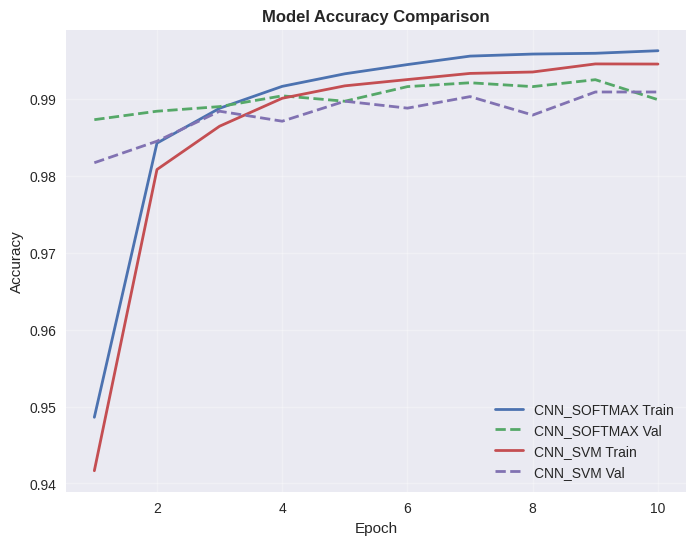

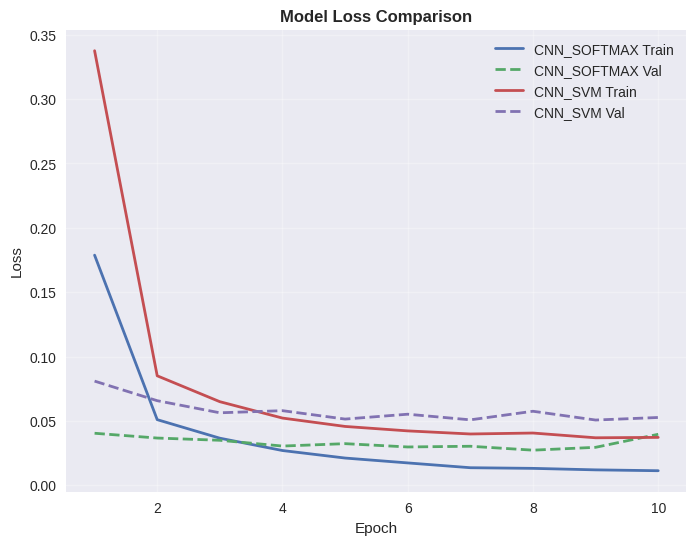

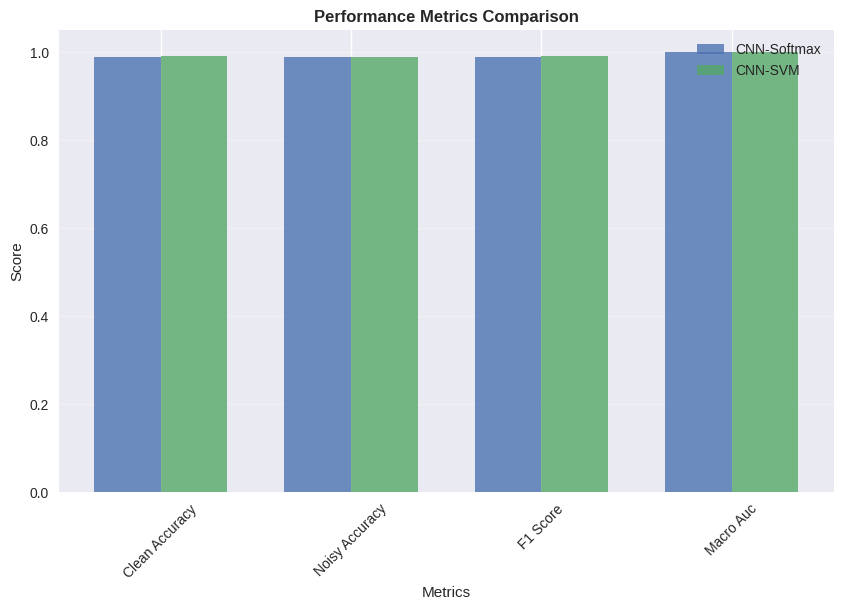

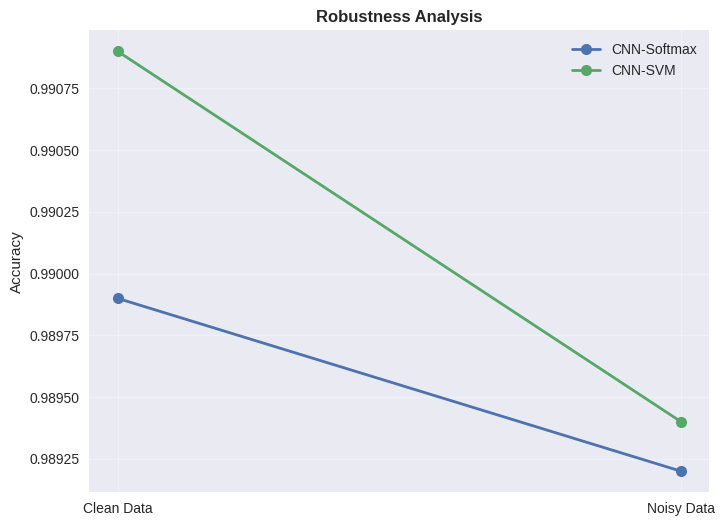

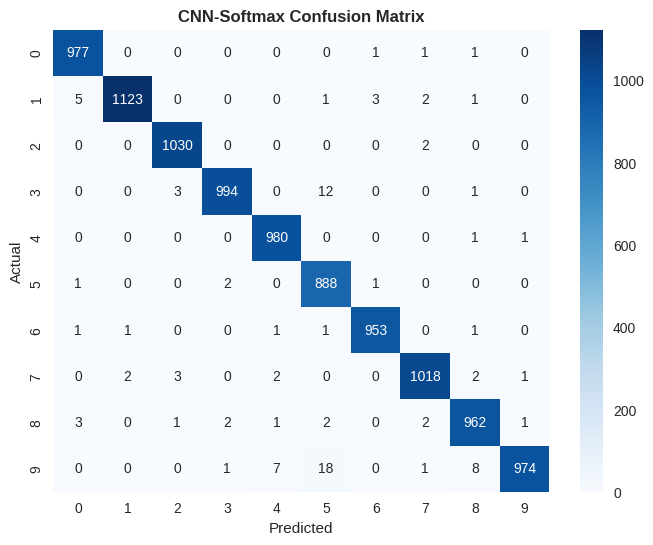

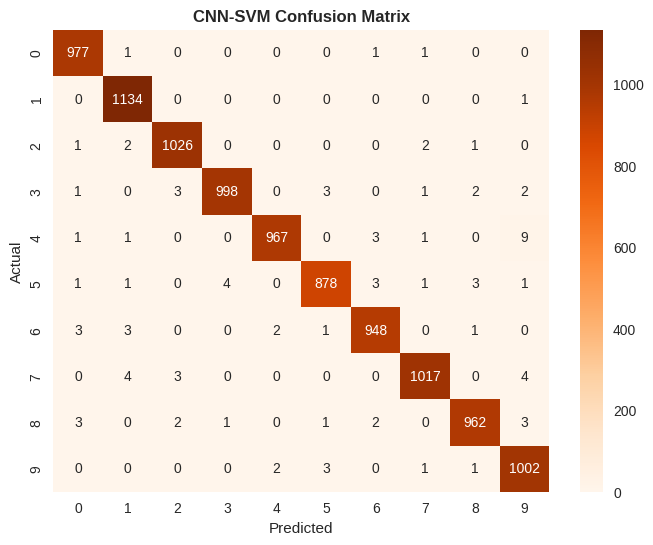

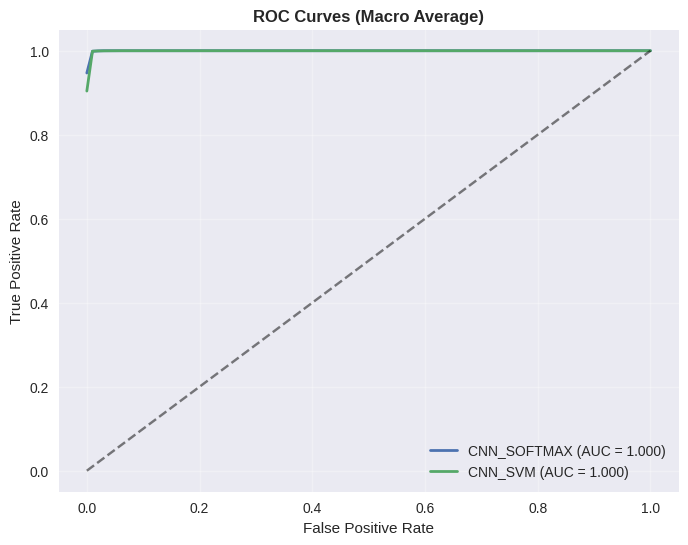

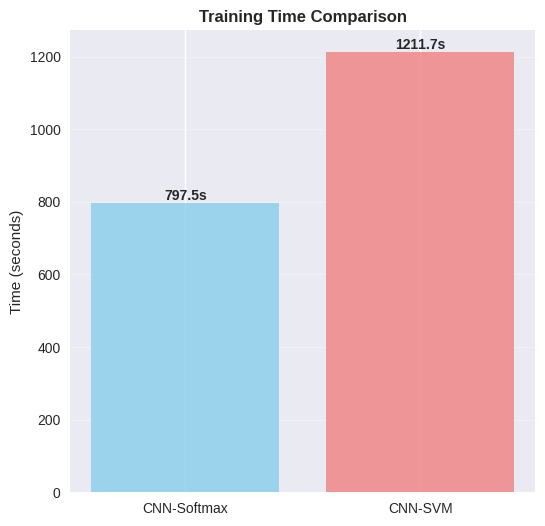

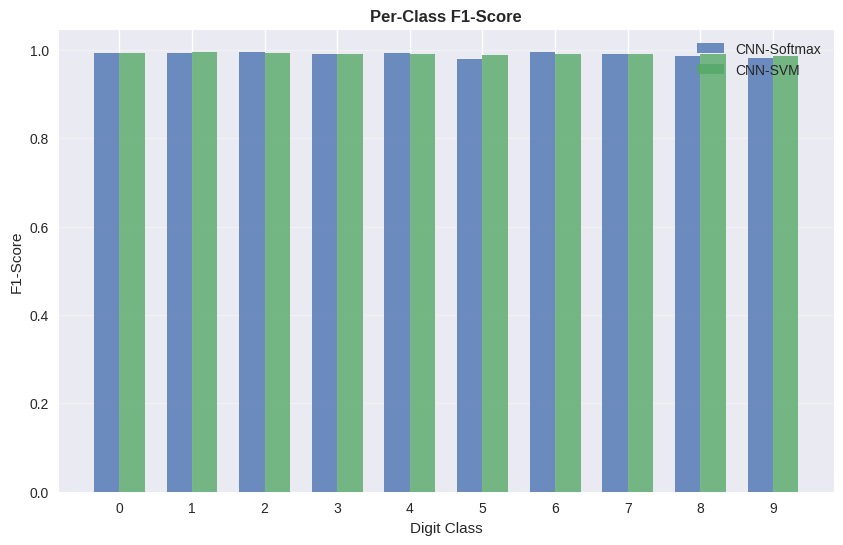

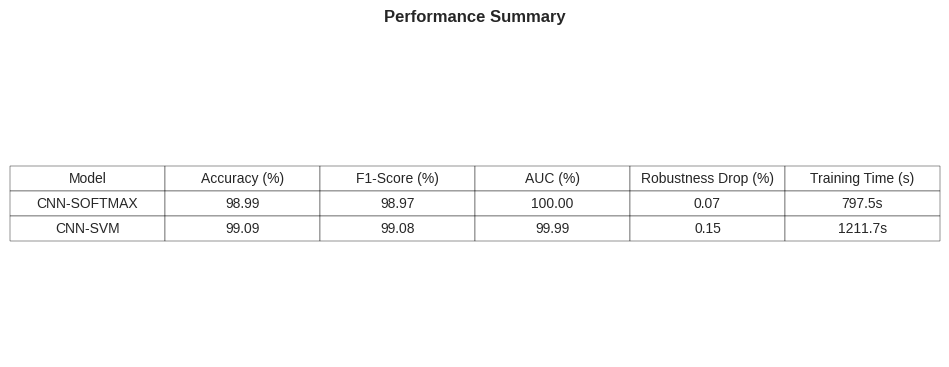


DETAILED RESULTS TABLE
             Metric CNN-Softmax CNN-SVM
       Accuracy (%)       98.99   99.09
      Precision (%)       98.96   99.09
         Recall (%)       99.00   99.07
       F1-Score (%)       98.97   99.08
            AUC (%)      100.00   99.99
Robustness Drop (%)        0.07    0.15
  Training Time (s)       797.5  1211.7

STUDY COMPLETED SUCCESSFULLY!
Results saved as 'model_comparison_results.csv'
Individual visualizations saved as separate PNG files.


In [93]:
if __name__ == "__main__":
    evaluator, results = main()